# Import the required modules.

In [1]:
pip install numpy pandas matplotlib seaborn keras scikit-learn tensorflow


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

2025-04-28 08:30:15.855719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 08:30:15.941828: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 08:30:15.944642: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-28 08:30:15.944657: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

# number_of_samples determine how many samples from the attack and normal dataset should be read and used.

In [4]:
number_of_samples = 50000

# Read data from attack and normal datasets.

In [5]:
data_attack = pd.read_csv('./dataset_attack.csv', nrows = number_of_samples)

In [6]:
data_normal = pd.read_csv('./dataset_normal.csv', nrows = number_of_samples)

In [7]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

# Drop unwanted columns

In [8]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [9]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [10]:
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

# Standardise the data

In [11]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

# the class field, replace value 'attack' with 0 and 'normal' with 1

In [12]:
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1
    

After feature transformation, we get a 𝑚×𝑛' matrix, where 𝑚 indicates the number of packets and 𝑛' indicates the number of new features after transformation. In order to learn patterns in both long and short term, we use a sliding window to separate continuous packets and reshape the data into a series of time windows with window size 𝑇. The label 𝑦 in each window illustrates the last packet. After reshaping, we have a three-dimensional matrix with shape (𝑚−𝑇 )×𝑇 ×𝑛'. Figure illustrates the workflow of feature extraction, transformation, and reshaping.
![dataset transformation](feature_extraction.png)
In this way, we change the features from conventional packet-based to window-based, by which we can learn network patterns from both previous (𝑇 −1) packets and current packet.

In [13]:
features = len(X[0])
samples = X.shape[0]
train_len = 25
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [14]:
X.shape

(100000, 25)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:100000], test_size = 0.2)

In [16]:
import numpy as np

# Convert Y_train to numpy array of integers (if binary classification)
Y_train = np.array(Y_train, dtype=np.int32)
Y_test = np.array(Y_test, dtype=np.int32)


# Or, if it's a regression problem, you can use float32
# Y_train = np.array(Y_train, dtype=np.float32)

# Verify the dtype
print(Y_train.dtype)


int32


The architecture used is 
![Model](model_brnn.png)

In [17]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [18]:
print(Y_train[:10])  # Inspect the first 10 entries


[1 0 1 1 0 1 0 1 0 0]


In [ ]:
model = create_baseline()

2025-04-05 19:24:01.348455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-05 19:24:01.351017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-05 19:24:01.351066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-04-05 19:24:01.351099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-04-05 19:24:01.351130: W tensorflow/c

In [19]:
history = model.fit(X_train, Y_train, epochs = 40,validation_split=0.2, verbose = 1)

NameError: name 'model' is not defined

Obtained plot of accuracy

![plot of accuracy](BRNN_Model_Accuracy.png)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('BRNN Model Accuracy')


KeyError: 'acc'

Text(0, 0.5, 'Accuracy')

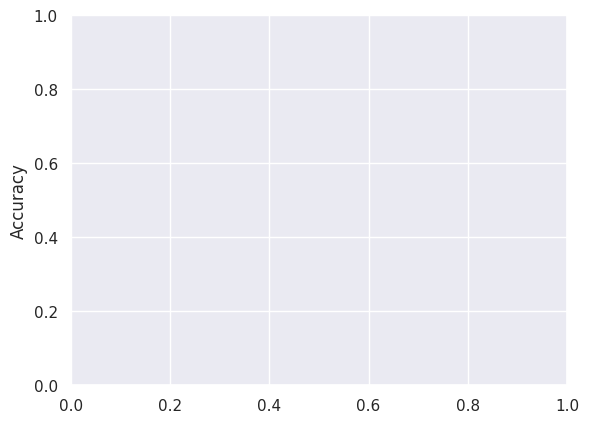

In [ ]:
plt.ylabel('Accuracy')


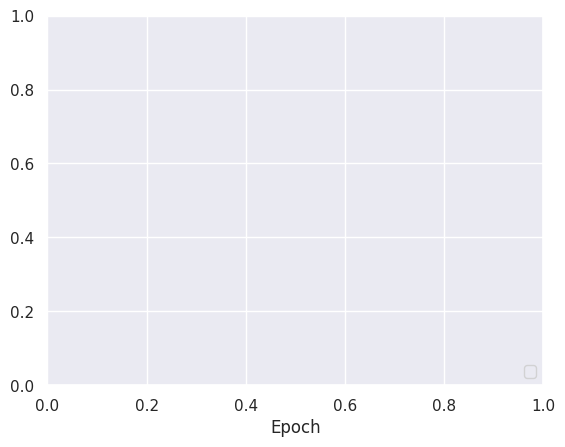

In [ ]:
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

Plot of loss
![plot of loss](BRNN_Model_Loss.png)

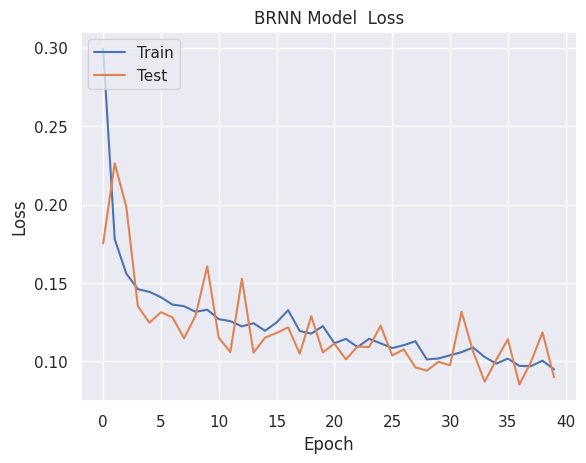

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()


In [ ]:
predict = model.predict(X_test, verbose=1)

625/625 [==============================] - 3s 5ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [20]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


NameError: name 'predict' is not defined

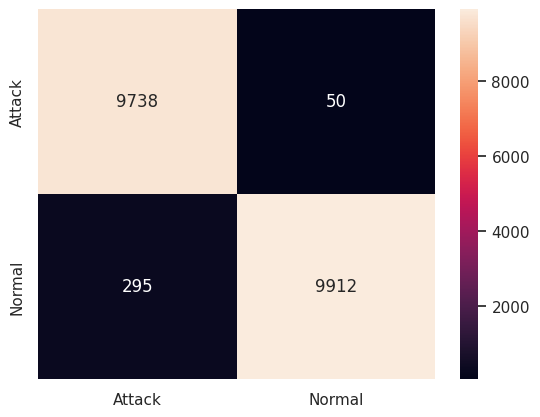

In [ ]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

# Save details 

In [ ]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [ ]:
model.save('brnn_model.h5')

In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.27%


In [ ]:
pip install pyshark


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pyshark

625/625 [==============================] - 3s 5ms/step - loss: 0.0889 - accuracy: 0.9827
Test accuracy: 0.9827, Test loss: 0.0889
625/625 [==============================] - 3s 5ms/step
Confusion Matrix:
[[9738  295]
 [  50 9912]]


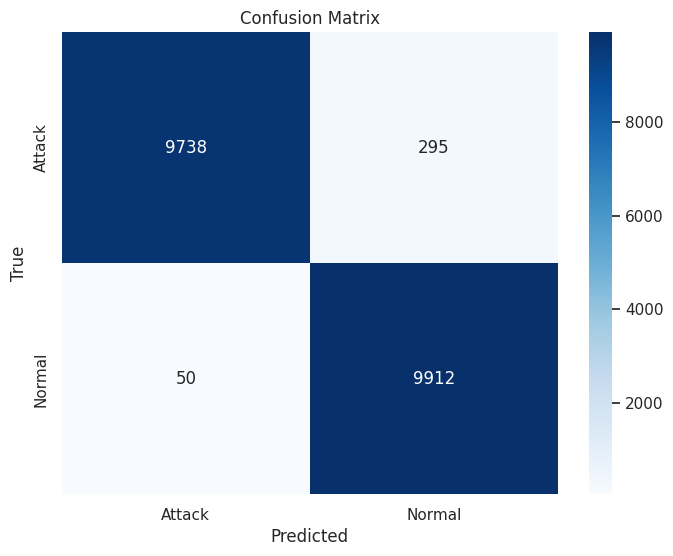

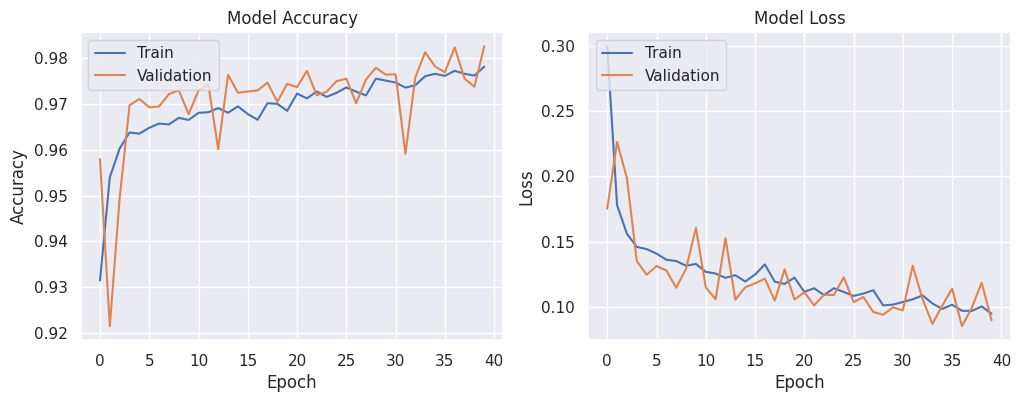

In [ ]:
# Load the saved model
loaded_model = load_model('brnn_model.h5')

# Evaluate on test data
test_loss, test_acc = loaded_model.evaluate(X_test, Y_test, verbose=1)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

# Make predictions
y_pred = loaded_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Attack', 'Normal'], 
            yticklabels=['Attack', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history (if you want to see training curves)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
import pyshark
import pandas as pd
import os
import asyncio
from datetime import datetime
import nest_asyncio  # Needed for Jupyter environments

# Apply nest_asyncio patch for Jupyter/IPython
nest_asyncio.apply()

def configure_tshark():
    try:
        # Set tshark path - adjust for your system
        pyshark.tshark.tshark.get_process_path = lambda *args: "/usr/bin/tshark"
        return True
    except Exception as e:
        print(f"Error configuring tshark: {e}")
        return False

def extract_packet_features(packet):
    """Extract required features from a network packet."""
    try:
        data = {
            'timestamp': datetime.now().isoformat(),
            'frame.len': int(packet.length),
            'ip.hdr_len': int(packet.ip.hdr_len) if hasattr(packet, 'ip') else 0,
            'ip.len': int(packet.ip.len) if hasattr(packet, 'ip') else 0,
            'ip.flags.rb': int(packet.ip.flags_rb) if hasattr(packet, 'ip') else 0,
            'ip.flags.df': int(packet.ip.flags_df) if hasattr(packet, 'ip') else 0,
            'ip.flags.mf': int(packet.ip.flags_mf) if hasattr(packet, 'ip') else 0,
            'ip.frag_offset': int(packet.ip.frag_offset) if hasattr(packet, 'ip') else 0,
            'ip.ttl': int(packet.ip.ttl) if hasattr(packet, 'ip') else 0,
            'ip.proto': int(packet.ip.proto) if hasattr(packet, 'ip') else 0,
            'tcp.srcport': int(packet.tcp.srcport) if hasattr(packet, 'tcp') else 0,
            'tcp.dstport': int(packet.tcp.dstport) if hasattr(packet, 'tcp') else 0,
            'tcp.len': int(packet.tcp.len) if hasattr(packet, 'tcp') else 0,
            'tcp.ack': int(packet.tcp.ack) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.res': int(packet.tcp.flags_res) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.ns': int(packet.tcp.flags_ns) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.cwr': int(packet.tcp.flags_cwr) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.ecn': int(packet.tcp.flags_ecn) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.urg': int(packet.tcp.flags_urg) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.ack': int(packet.tcp.flags_ack) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.push': int(packet.tcp.flags_push) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.reset': int(packet.tcp.flags_reset) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.syn': int(packet.tcp.flags_syn) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.fin': int(packet.tcp.flags_fin) if hasattr(packet, 'tcp') else 0,
            'tcp.window_size': int(packet.tcp.window_size) if hasattr(packet, 'tcp') else 0,
            'tcp.time_delta': float(packet.tcp.time_delta) if hasattr(packet, 'tcp') else 0,
            'protocol': packet.highest_layer if hasattr(packet, 'highest_layer') else 'UNKNOWN'
        }
        return data
    except Exception as e:
        print(f"Error processing packet: {e}")
        return None

async def async_capture(interface, packet_count):
    """Asynchronous packet capture function"""
    cap = pyshark.LiveCapture(interface=interface)
    data_list = []
    
    try:
        for i, packet in enumerate(cap.sniff_continuously()):
            if i >= packet_count:
                break
                
            packet_features = extract_packet_features(packet)
            if packet_features:
                data_list.append(packet_features)
                print(f"Captured packet {i+1}/{packet_count}", end='\r')
                
    except KeyboardInterrupt:
        print("\nCapture stopped by user.")
    finally:
        await cap.close_async()
        
    return data_list

def capture_packets(interface="wlp0s20f3", packet_count=50, output_file=None):
    """Main capture function that handles the async operations"""
    if not configure_tshark():
        print("Failed to configure tshark. Exiting.")
        return None
    
    if output_file is None:
        output_file = f"network_capture_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    
    try:
        print(f"Starting capture on interface {interface}...")
        print(f"Capturing {packet_count} packets... Press Ctrl+C to stop early.")
        
        # Run the async capture
        loop = asyncio.get_event_loop()
        data_list = loop.run_until_complete(async_capture(interface, packet_count))
        
        # Create DataFrame and save to CSV
        if data_list:
            df = pd.DataFrame(data_list)
            df.to_csv(output_file, index=False)
            print(f"\nCapture complete. Saved {len(data_list)} packets to {output_file}")
            return df
        else:
            print("No packets were captured.")
            return None
            
    except Exception as e:
        print(f"Error during capture: {e}")
        return None

if __name__ == "__main__":
    # Example usage
    interface = "wlp0s20f3"  # Change to your network interface
    packet_count = 100        # Number of packets to capture
    output_file = "network_traffic.csv"  # Output filename
    
    print(f"Starting network capture on interface {interface}")
    df = capture_packets(interface=interface, packet_count=packet_count, output_file=output_file)
    
    if df is not None:
        print("\nFirst 5 captured packets:")
        print(df.head())

Starting network capture on interface wlp0s20f3
Starting capture on interface wlp0s20f3...
Capturing 100 packets... Press Ctrl+C to stop early.
Captured packet 100/100
Capture complete. Saved 100 packets to network_traffic.csv

First 5 captured packets:
                    timestamp  frame.len  ip.hdr_len  ip.len  ip.flags.rb  \
0  2025-04-28T08:31:22.858304        184          20     170            0   
1  2025-04-28T08:31:22.868466       4419          20    4405            0   
2  2025-04-28T08:31:22.871044         66          20      52            0   
3  2025-04-28T08:31:22.873180         66          20      52            0   
4  2025-04-28T08:31:22.874781         66          20      52            0   

   ip.flags.df  ip.flags.mf  ip.frag_offset  ip.ttl  ip.proto  ...  \
0            1            0               0      64         6  ...   
1            1            0               0      64         6  ...   
2            0            0               0      63         6  ...   
3  

In [3]:
import pyshark
import pandas as pd
import numpy as np
from datetime import datetime
import asyncio
import nest_asyncio
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Apply nest_asyncio patch for Jupyter environments
nest_asyncio.apply()

# Load your pre-trained model and scaler
model = load_model('brnn_model.h5')
scalar = StandardScaler()

# Define the features in the exact same order as during training
features = ['frame.len', 'ip.hdr_len', 'ip.len', 'ip.flags.rb', 'ip.flags.df', 
            'ip.flags.mf', 'ip.frag_offset', 'ip.ttl', 'ip.proto', 'tcp.srcport', 
            'tcp.dstport', 'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 
            'tcp.flags.cwr', 'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 
            'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 
            'tcp.window_size', 'tcp.time_delta']

def configure_tshark():
    try:
        # Set tshark path - adjust for your system
        pyshark.tshark.tshark.get_process_path = lambda *args: "/usr/bin/tshark"
        return True
    except Exception as e:
        print(f"Error configuring tshark: {e}")
        return False

def extract_packet_features(packet):
    """Extract required features from a network packet."""
    try:
        data = {
            'timestamp': datetime.now().isoformat(),
            'frame.len': int(packet.length),
            'ip.hdr_len': int(packet.ip.hdr_len) if hasattr(packet, 'ip') else 0,
            'ip.len': int(packet.ip.len) if hasattr(packet, 'ip') else 0,
            'ip.flags.rb': int(packet.ip.flags_rb) if hasattr(packet, 'ip') else 0,
            'ip.flags.df': int(packet.ip.flags_df) if hasattr(packet, 'ip') else 0,
            'ip.flags.mf': int(packet.ip.flags_mf) if hasattr(packet, 'ip') else 0,
            'ip.frag_offset': int(packet.ip.frag_offset) if hasattr(packet, 'ip') else 0,
            'ip.ttl': int(packet.ip.ttl) if hasattr(packet, 'ip') else 0,
            'ip.proto': int(packet.ip.proto) if hasattr(packet, 'ip') else 0,
            'tcp.srcport': int(packet.tcp.srcport) if hasattr(packet, 'tcp') else 0,
            'tcp.dstport': int(packet.tcp.dstport) if hasattr(packet, 'tcp') else 0,
            'tcp.len': int(packet.tcp.len) if hasattr(packet, 'tcp') else 0,
            'tcp.ack': int(packet.tcp.ack) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.res': int(packet.tcp.flags_res) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.ns': int(packet.tcp.flags_ns) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.cwr': int(packet.tcp.flags_cwr) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.ecn': int(packet.tcp.flags_ecn) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.urg': int(packet.tcp.flags_urg) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.ack': int(packet.tcp.flags_ack) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.push': int(packet.tcp.flags_push) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.reset': int(packet.tcp.flags_reset) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.syn': int(packet.tcp.flags_syn) if hasattr(packet, 'tcp') else 0,
            'tcp.flags.fin': int(packet.tcp.flags_fin) if hasattr(packet, 'tcp') else 0,
            'tcp.window_size': int(packet.tcp.window_size) if hasattr(packet, 'tcp') else 0,
            'tcp.time_delta': float(packet.tcp.time_delta) if hasattr(packet, 'tcp') else 0,
        }
        return data
    except Exception as e:
        print(f"Error processing packet: {e}")
        return None

class TrafficAnalyzer:
    def __init__(self, window_size=25):
        self.window_size = window_size
        self.packet_buffer = []
        self.scaler = StandardScaler()
        
    def add_packet(self, packet_features):
        """Add a packet to the buffer and analyze if we have enough packets"""
        self.packet_buffer.append(packet_features)
        
        # Keep only the last window_size packets
        if len(self.packet_buffer) > self.window_size:
            self.packet_buffer = self.packet_buffer[-self.window_size:]
            
        # If we have enough packets, analyze them
        if len(self.packet_buffer) == self.window_size:
            self.analyze_traffic()
    
    def analyze_traffic(self):
        """Analyze the current window of packets"""
        # Convert to DataFrame
        df_window = pd.DataFrame(self.packet_buffer)
        
        # Extract features in correct order
        X_window = df_window[features].values
        
        # Scale the features (you should fit the scaler on your training data first)
        X_scaled = scalar.transform(X_window)
        
        # Reshape for LSTM input (1 sample, window_size timesteps, n_features)
        X_reshaped = X_scaled.reshape(1, self.window_size, len(features))
        
        # Make prediction
        prediction = model.predict(X_reshaped)
        prediction_class = "ATTACK" if prediction[0][0] < 0.5 else "NORMAL"
        confidence = prediction[0][0] if prediction_class == "NORMAL" else 1 - prediction[0][0]
        
        # Print results with color coding
        if prediction_class == "ATTACK":
            print(f"\033[91mALERT: Potential attack detected! (Confidence: {confidence:.2%})\033[0m")
        else:
            print(f"\033[92mStatus: Normal traffic (Confidence: {confidence:.2%})\033[0m")

async def async_capture(interface, packet_count=None):
    """Asynchronous packet capture function"""
    analyzer = TrafficAnalyzer()
    cap = pyshark.LiveCapture(interface=interface)
    
    try:
        print("\033[94mStarting real-time network monitoring...\033[0m")
        print("\033[94mPress Ctrl+C to stop\033[0m")
        
        for i, packet in enumerate(cap.sniff_continuously()):
            if packet_count and i >= packet_count:
                break
                
            packet_features = extract_packet_features(packet)
            if packet_features:
                analyzer.add_packet(packet_features)
                
    except KeyboardInterrupt:
        print("\nCapture stopped by user.")
    finally:
        await cap.close_async()

def monitor_network(interface="wlp0s20f3", packet_count=None):
    """Main function to monitor network traffic"""
    if not configure_tshark():
        print("Failed to configure tshark. Exiting.")
        return
    
    try:
        # Run the async capture
        loop = asyncio.get_event_loop()
        loop.run_until_complete(async_capture(interface, packet_count))
    except Exception as e:
        print(f"Error during capture: {e}")

if __name__ == "__main__":
    # IMPORTANT: Fit the scaler on your training data before using this
    # For demonstration, we'll create a dummy scaler - replace with your actual scaler
    dummy_data = np.random.rand(100, len(features))
    scalar.fit(dummy_data)
    
    # Start monitoring
    interface = "wlp0s20f3"  # Change to your network interface
    monitor_network(interface=interface)

Task was destroyed but it is pending!
task: <Task pending coro=<BaseSubprocessTransport._connect_pipes() done, defined at /usr/lib/python3.7/asyncio/base_subprocess.py:157> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f68c2006950>()]>>


Starting real-time network monitoring...
Press Ctrl+C to stop
1/1 [==============================] - 1s 652ms/step
Status: Normal traffic (Confidence: 81.65%)
1/1 [==============================] - 0s 24ms/step
Status: Normal traffic (Confidence: 75.10%)
1/1 [==============================] - 0s 24ms/step
Status: Normal traffic (Confidence: 78.96%)
1/1 [==============================] - 0s 23ms/step
Status: Normal traffic (Confidence: 77.76%)
1/1 [==============================] - 0s 23ms/step
Status: Normal traffic (Confidence: 71.79%)
1/1 [==============================] - 0s 23ms/step
Status: Normal traffic (Confidence: 67.83%)
1/1 [==============================] - 0s 23ms/step
Status: Normal traffic (Confidence: 66.06%)
1/1 [==============================] - 0s 24ms/step
Status: Normal traffic (Confidence: 65.78%)
1/1 [==============================] - 0s 22ms/step
Status: Normal traffic (Confidence: 66.25%)
1/1 [==============================] - 0s 23ms/step
Status: Normal traffi

In [4]:
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox
import threading
import pyshark
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class NetworkMonitorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Network Traffic Monitor with Attack Detection")
        self.root.geometry("900x700")
        
        # Model and scaler initialization
        self.model = None
        self.scalar = StandardScaler()
        self.features = ['frame.len', 'ip.hdr_len', 'ip.len', 'ip.flags.rb', 'ip.flags.df', 
                        'ip.flags.mf', 'ip.frag_offset', 'ip.ttl', 'ip.proto', 'tcp.srcport', 
                        'tcp.dstport', 'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 
                        'tcp.flags.cwr', 'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 
                        'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 
                        'tcp.window_size', 'tcp.time_delta']
        
        # Packet capture control
        self.capture_active = False
        self.capture_thread = None
        
        # Create UI elements
        self.create_widgets()
        
        # Load model (you should have brnn_model.h5 in the same directory)
        try:
            self.model = load_model('brnn_model.h5')
            # Initialize scaler with dummy data (replace with your actual scaler)
            dummy_data = np.random.rand(100, len(self.features))
            self.scalar.fit(dummy_data)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model: {str(e)}")
    
    def create_widgets(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Settings frame
        settings_frame = ttk.LabelFrame(main_frame, text="Capture Settings", padding="10")
        settings_frame.pack(fill=tk.X, pady=5)
        
        # Interface selection
        ttk.Label(settings_frame, text="Network Interface:").grid(row=0, column=0, sticky=tk.W)
        self.interface_var = tk.StringVar(value="wlp0s20f3")
        self.interface_entry = ttk.Entry(settings_frame, textvariable=self.interface_var, width=20)
        self.interface_entry.grid(row=0, column=1, sticky=tk.W)
        
        # Window size
        ttk.Label(settings_frame, text="Analysis Window Size:").grid(row=0, column=2, sticky=tk.W)
        self.window_size_var = tk.IntVar(value=25)
        self.window_size_spin = ttk.Spinbox(settings_frame, from_=10, to=100, textvariable=self.window_size_var, width=5)
        self.window_size_spin.grid(row=0, column=3, sticky=tk.W)
        
        # Control buttons
        button_frame = ttk.Frame(main_frame)
        button_frame.pack(fill=tk.X, pady=5)
        
        self.start_button = ttk.Button(button_frame, text="Start Monitoring", command=self.start_capture)
        self.start_button.pack(side=tk.LEFT, padx=5)
        
        self.stop_button = ttk.Button(button_frame, text="Stop Monitoring", command=self.stop_capture, state=tk.DISABLED)
        self.stop_button.pack(side=tk.LEFT, padx=5)
        
        # Status display
        status_frame = ttk.LabelFrame(main_frame, text="Status", padding="10")
        status_frame.pack(fill=tk.X, pady=5)
        
        self.status_text = scrolledtext.ScrolledText(status_frame, height=5, wrap=tk.WORD)
        self.status_text.pack(fill=tk.BOTH, expand=True)
        self.status_text.tag_config("normal", foreground="green")
        self.status_text.tag_config("attack", foreground="red")
        self.status_text.tag_config("info", foreground="blue")
        
        # Statistics frame
        stats_frame = ttk.LabelFrame(main_frame, text="Statistics", padding="10")
        stats_frame.pack(fill=tk.BOTH, expand=True, pady=5)
        
        # Packet count
        # ttk.Label(stats_frame, text="Packets Captured:").grid(row=0, column=0, sticky=tk.W)
        # self.packet_count_var = tk.StringVar(value="0")
        # ttk.Label(stats_frame, textvariable=self.packet_count_var).grid(row=0, column=1, sticky=tk.W)
        
        # Normal traffic
        ttk.Label(stats_frame, text="Normal Traffic:").grid(row=1, column=0, sticky=tk.W)
        self.normal_count_var = tk.StringVar(value="0")
        ttk.Label(stats_frame, textvariable=self.normal_count_var, foreground="green").grid(row=1, column=1, sticky=tk.W)
        
        # Attack traffic
        ttk.Label(stats_frame, text="Attack Traffic:").grid(row=2, column=0, sticky=tk.W)
        self.attack_count_var = tk.StringVar(value="0")
        ttk.Label(stats_frame, textvariable=self.attack_count_var, foreground="red").grid(row=2, column=1, sticky=tk.W)
        
        # Log display
        log_frame = ttk.LabelFrame(stats_frame, text="Recent Events", padding="10")
        log_frame.grid(row=3, column=0, columnspan=4, sticky=tk.W+tk.E, pady=5)
        
        self.log_text = scrolledtext.ScrolledText(log_frame, height=10, wrap=tk.WORD)
        self.log_text.pack(fill=tk.BOTH, expand=True)
        self.log_text.tag_config("normal", foreground="green")
        self.log_text.tag_config("attack", foreground="red")
    
    def log_message(self, message, tag=None):
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.log_text.insert(tk.END, f"[{timestamp}] {message}\n", tag)
        self.log_text.see(tk.END)
        self.root.update()
    
    def update_status(self, message, tag=None):
        self.status_text.insert(tk.END, f"{message}\n", tag)
        self.status_text.see(tk.END)
        self.root.update()
    
    def start_capture(self):
        if self.capture_active:
            return
        
        if not self.model:
            messagebox.showerror("Error", "Model not loaded!")
            return
        
        interface = self.interface_var.get()
        if not interface:
            messagebox.showerror("Error", "Please specify a network interface")
            return
        
        self.capture_active = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        
        # Reset counters
        self.packet_count = 0
        self.normal_count = 0
        self.attack_count = 0
        # self.packet_count_var.set("0")
        self.normal_count_var.set("0")
        self.attack_count_var.set("0")
        
        self.update_status(f"Starting capture on interface {interface}...", "info")
        self.log_message(f"Monitoring started on {interface}", "info")
        
        # Start capture in a separate thread
        self.capture_thread = threading.Thread(
            target=self.run_capture,
            args=(interface, self.window_size_var.get()),
            daemon=True
        )
        self.capture_thread.start()
    
    def stop_capture(self):
        if not self.capture_active:
            return
        
        self.capture_active = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)
        
        self.update_status("Stopping capture...", "info")
        self.log_message("Monitoring stopped", "info")
    
    def run_capture(self, interface, window_size):
        analyzer = TrafficAnalyzer(self, window_size)
        
        try:
            cap = pyshark.LiveCapture(interface=interface)
            
            for packet in cap.sniff_continuously():
                if not self.capture_active:
                    break
                
                packet_features = self.extract_packet_features(packet)
                if packet_features:
                    analyzer.add_packet(packet_features)
                    self.packet_count += 1
                    # self.packet_count_var.set(str(self.packet_count))
        
        except Exception as e:
            self.root.after(0, lambda: self.update_status(f"Error: {str(e)}", "attack"))
            self.root.after(0, lambda: self.log_message(f"Error: {str(e)}", "attack"))
        
        self.root.after(0, lambda: self.update_status("Capture stopped", "info"))
        self.root.after(0, self.stop_capture)
    
    def extract_packet_features(self, packet):
        try:
            data = {
                'timestamp': datetime.now().isoformat(),
                'frame.len': int(packet.length),
                'ip.hdr_len': int(packet.ip.hdr_len) if hasattr(packet, 'ip') else 0,
                'ip.len': int(packet.ip.len) if hasattr(packet, 'ip') else 0,
                'ip.flags.rb': int(packet.ip.flags_rb) if hasattr(packet, 'ip') else 0,
                'ip.flags.df': int(packet.ip.flags_df) if hasattr(packet, 'ip') else 0,
                'ip.flags.mf': int(packet.ip.flags_mf) if hasattr(packet, 'ip') else 0,
                'ip.frag_offset': int(packet.ip.frag_offset) if hasattr(packet, 'ip') else 0,
                'ip.ttl': int(packet.ip.ttl) if hasattr(packet, 'ip') else 0,
                'ip.proto': int(packet.ip.proto) if hasattr(packet, 'ip') else 0,
                'tcp.srcport': int(packet.tcp.srcport) if hasattr(packet, 'tcp') else 0,
                'tcp.dstport': int(packet.tcp.dstport) if hasattr(packet, 'tcp') else 0,
                'tcp.len': int(packet.tcp.len) if hasattr(packet, 'tcp') else 0,
                'tcp.ack': int(packet.tcp.ack) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.res': int(packet.tcp.flags_res) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.ns': int(packet.tcp.flags_ns) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.cwr': int(packet.tcp.flags_cwr) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.ecn': int(packet.tcp.flags_ecn) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.urg': int(packet.tcp.flags_urg) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.ack': int(packet.tcp.flags_ack) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.push': int(packet.tcp.flags_push) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.reset': int(packet.tcp.flags_reset) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.syn': int(packet.tcp.flags_syn) if hasattr(packet, 'tcp') else 0,
                'tcp.flags.fin': int(packet.tcp.flags_fin) if hasattr(packet, 'tcp') else 0,
                'tcp.window_size': int(packet.tcp.window_size) if hasattr(packet, 'tcp') else 0,
                'tcp.time_delta': float(packet.tcp.time_delta) if hasattr(packet, 'tcp') else 0,
            }
            return data
        except Exception as e:
            self.root.after(0, lambda: self.log_message(f"Packet error: {str(e)}", "attack"))
            return None

class TrafficAnalyzer:
    def __init__(self, app, window_size=25):
        self.app = app
        self.window_size = window_size
        self.packet_buffer = []
    
    def add_packet(self, packet_features):
        self.packet_buffer.append(packet_features)
        
        if len(self.packet_buffer) > self.window_size:
            self.packet_buffer = self.packet_buffer[-self.window_size:]
            
        if len(self.packet_buffer) == self.window_size:
            self.analyze_traffic()
    
    def analyze_traffic(self):
        df_window = pd.DataFrame(self.packet_buffer)
        X_window = df_window[self.app.features].values
        
        try:
            X_scaled = self.app.scalar.transform(X_window)
            X_reshaped = X_scaled.reshape(1, self.window_size, len(self.app.features))
            
            prediction = self.app.model.predict(X_reshaped)
            prediction_class = "NORMAL" if prediction[0][0] >= 0.5 else "ATTACK"
            confidence = prediction[0][0] if prediction_class == "NORMAL" else 1 - prediction[0][0]
            
            if prediction_class == "ATTACK":
                self.app.root.after(0, lambda: self.app.log_message(
                    f"Potential attack detected! (Confidence: {confidence:.2%})", "attack"))
                self.app.attack_count += 1
                self.app.attack_count_var.set(str(self.app.attack_count))
            else:
                self.app.root.after(0, lambda: self.app.log_message(
                    f"Normal traffic (Confidence: {confidence:.2%})", "normal"))
                self.app.normal_count += 1
                self.app.normal_count_var.set(str(self.app.normal_count))
                
        except Exception as e:
            self.app.root.after(0, lambda: self.app.log_message(
                f"Analysis error: {str(e)}", "attack"))

if __name__ == "__main__":
    root = tk.Tk()
    app = NetworkMonitorApp(root)
    root.mainloop()

1/1 [==============================] - 0s 22ms/step


In [2]:
import psutil

# Get all network interfaces
interfaces = psutil.net_if_addrs()

print("Available Network Interfaces:")
for interface in interfaces:
    print(f"- {interface}")


Available Network Interfaces:
- lo
- wlp0s20f3
- br-ae28863e001c
- br-e6a734a1817b
- docker0
- br-274125a54d8d
- br-68fad4d03fcb
- br-90a25aa1b821
- veth4e3e44d
- vethb8b6629
- veth34b0558
- veth4c6fbe3
- enp67s0


In [ ]:
pip freeze

absl-py==2.1.0
appdirs==1.4.4
astunparse==1.6.3
backcall==0.2.0
cachetools==5.5.0
certifi==2024.12.14
charset-normalizer==3.4.1
cycler==0.11.0
debugpy==1.7.0
decorator==5.1.1
entrypoints==0.4
flatbuffers==24.12.23
fonttools==4.38.0
gast==0.4.0
google-auth==2.37.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.62.3
h5py==3.8.0
idna==3.10
importlib-metadata==6.7.0
ipykernel==6.16.2
ipython==7.34.0
jedi==0.19.2
joblib==1.3.2
jupyter_client==7.4.9
jupyter_core==4.12.0
keras==2.11.0
kiwisolver==1.4.5
libclang==18.1.1
lxml==5.3.1
Markdown==3.4.4
MarkupSafe==2.1.5
matplotlib==3.5.3
matplotlib-inline==0.1.6
nest-asyncio==1.6.0
numpy==1.21.6
oauthlib==3.2.2
opt-einsum==3.3.0
packaging==24.0
pandas==1.3.5
parso==0.8.4
pexpect==4.9.0
pickleshare==0.7.5
Pillow==9.5.0
prompt_toolkit==3.0.48
protobuf==3.19.6
psutil==6.1.1
ptyprocess==0.7.0
pyasn1==0.5.1
pyasn1-modules==0.3.0
Pygments==2.17.2
pyparsing==3.1.4
pyshark==0.6
python-dateutil==2.9.0.post0
pytz==2024.2
pyzmq==26.2.0
requests==2.